In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import models
import os
from tensorflow.keras.preprocessing.image import *
from skimage import io
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.vgg16 import *

In [ ]:
base_dir = os.path.expanduser("/mnt/d/BDA602/FruitsVegetables")

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
validation_dir = os.path.join(base_dir, "validation")

train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=100,
    image_size=(224, 224),
    batch_size=256,
    shuffle=True,
    label_mode="int"
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=100,
    image_size=(224, 224),
    batch_size=256,
    shuffle=True,
    label_mode="int"
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=100,
    image_size=(224, 224),
    batch_size=256,
    shuffle=True,
    label_mode="int"
)

In [ ]:
x_train, y_train = next(iter(train))
x_validation, y_validation = next(iter(validation))
x_test, y_test = next(iter(test))

x_train = tf.cast(x_train, 'float32') / 255.0
x_validation = tf.cast(x_validation, 'float32') / 255.0
x_test = tf.cast(x_test, 'float32') / 255.0

y_train_one_hot = to_categorical(y_train, 36)
y_validation_one_hot = to_categorical(y_validation, 36)
y_test_one_hot = to_categorical(y_test, 36)

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False
base_model.summary()

In [ ]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(36, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, 
    vertical_flip=True, 
    horizontal_flip=True, 
    zoom_range = 0.3, 
    shear_range = 0.3)

validation_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224, 224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size= (224, 224),
        batch_size = 36,
        color_mode= "rgb",
        class_mode= "categorical")

In [ ]:
filepath = '/mnt/d/BDA602/VGG16.keras'

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
hist = model.fit(
        x = train_generator,
        steps_per_epoch = 20,
        epochs=100,
        validation_data = validation_generator,
        validation_steps = 10,
        callbacks=[es, checkpoint])


7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7


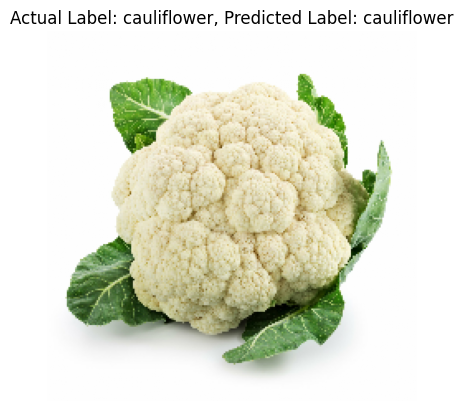

In [49]:
random_index = np.random.randint(len(x_test))

random_image = x_test[random_index]
actual_label = np.argmax(y_test_one_hot[random_index])

print(actual_label)

random_image = np.expand_dims(random_image, axis=0)

predicted_label = model.predict(random_image)

predicted_label = np.argmax(predicted_label)

print(predicted_label)

class_names = test.class_names

plt.imshow(random_image.squeeze())
plt.title(f"Actual Label: {class_names[actual_label]}, Predicted Label: {class_names[predicted_label]}")
plt.axis('off')
plt.show()

In [ ]:
plt.figure()
plt.plot(hist.history["loss"],label = "Train Loss", color = "black")
plt.plot(hist.history["val_loss"],label = "Validation Loss", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Loss", color = "darkred", size = 13)
plt.xlabel("Epoch")
plt.ylabel("Model Loss")
plt.legend()
plt.savefig("/mnt/d/BDA602/model_loss_plot_VGG16.png")
plt.show()

In [ ]:
plt.figure()
plt.plot(hist.history["accuracy"], label="Train Accuracy", color="black")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="darkred", linestyle="dashed", markeredgecolor="purple", markeredgewidth=2)
plt.title("Model Accuracy", color="darkred", size=13)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("/mnt/d/BDA602/model_accuracy_plot_VGG16.png")
plt.show()

In [47]:
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc * 100, '%')

Found 359 images belonging to 36 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8994 - loss: 0.4355
Test accuracy: 92.20055937767029 %
